In [24]:
spark

## Import modules

In [25]:
from pyspark.sql import functions as F
from pyspark.sql.types import FloatType, LongType
from pyspark.sql.functions import explode
import hsfs

In [26]:
import hsfs
# Create a connection
connection = hsfs.connection()
# Get the feature store handle for the project's feature store
fs = connection.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

In [51]:
def prep_alert_for_ploting(alert_id):
    demo_alert = alert_transactions_df.where(F.col("alert_id")==alert_id).select("src","dst","tran_timestamp")
    demo_nodes = party_df.join(
        demo_alert,
        [(party_df.id==demo_alert.src)|(party_df.id==demo_alert.dst)],
        how="inner"
    ).dropDuplicates(subset=['id']).drop(*["src", "dst", "tran_timestamp"])
    return demo_nodes, demo_alert

In [27]:
alert_transactions_fg = fs.get_feature_group("alert_transactions_fg",1)
alert_transactions_fg.show(5)

+--------+--------------+-------+------+
|alert_id|    alert_type|tran_id|is_sar|
+--------+--------------+-------+------+
|      52|gather_scatter| 447977|  true|
|      23|scatter_gather| 449282|  true|
|      52|gather_scatter| 454797|  true|
|      68|gather_scatter| 462363|  true|
|      68|gather_scatter| 468776|  true|
+--------+--------------+-------+------+
only showing top 5 rows

In [28]:
transactions_fg = fs.get_feature_group("transactions_fg",1)
transactions_fg.show(5)

+-------+--------------+-------+--------+--------+--------+
|tx_type|tran_timestamp|tran_id|     dst|     src|base_amt|
+-------+--------------+-------+--------+--------+--------+
|      4|        Jan-01|    496|1e46e726|3aa9646b|  858.77|
|      4|        Jan-01|   1342|a74d1101|49203bc3|  386.86|
|      4|        Jan-02|   1580|99af2455|616d4505|  616.43|
|      4|        Jan-02|   2866|e7ec7bdb|39be1ea2|  146.44|
|      4|        Jan-03|   3997|afc399a9|e2e0d938|  439.09|
+-------+--------------+-------+--------+--------+--------+
only showing top 5 rows

In [29]:
party_df = fs.get_feature_group("party_fg",1).read()
party_df.show(5)

+--------+----+
|      id|type|
+--------+----+
|5628bd6c|   0|
|a1fcba39|   0|
|f56c9501|   1|
|9969afdd|   0|
|b356eeae|   1|
+--------+----+
only showing top 5 rows

In [30]:
alert_transactions_df = alert_transactions_fg.select(["alert_type", "tran_id", "alert_id"])\
                                             .join(transactions_fg.select_all(),["tran_id"],"inner")\
                                             .read()

In [31]:
alert_transactions_df.groupBy("alert_type").agg(F.count("alert_type")).show()

+--------------+-----------------+
|    alert_type|count(alert_type)|
+--------------+-----------------+
|gather_scatter|              272|
|         cycle|              235|
|scatter_gather|              408|
+--------------+-----------------+

In [61]:
alert_transactions_df.where(F.col("alert_type")=="cycle").show()

+----------+-------+--------+-------+--------------+-------+--------+--------+--------+
|alert_type|tran_id|alert_id|tx_type|tran_timestamp|tran_id|     dst|     src|base_amt|
+----------+-------+--------+-------+--------------+-------+--------+--------+--------+
|     cycle| 811151|      88|      4|        Jul-21| 811151|e6c76032|b0fe7e18|  112.19|
|     cycle| 864390|      71|      4|        Aug-27| 864390|2a348960|5a89d195|  107.84|
|     cycle| 137352|      94|      4|        Apr-06| 137352|0c81ba35|4c52d76b|   94.95|
|     cycle| 856332|      99|      4|        Aug-21| 856332|19857dba|edfe718c|   103.5|
|     cycle| 248494|      82|      4|        Jun-22| 248494|11d52a92|208d7af9|   66.64|
|     cycle| 980285|      95|      4|        Nov-16| 980285|6d9d3784|9cf31a21|  129.78|
|     cycle| 721517|      91|      4|        May-19| 721517|d0ba8246|308d1047|   92.67|
|     cycle| 103476|      75|      4|        Mar-13| 103476|16fcc326|bbc48e4b|   73.36|
|     cycle| 654498|      98|   

In [52]:
#gather_scatter
demo_nodes, demo_alert = prep_alert_for_ploting(alert_id="58")

In [53]:
%%spark -o demo_nodes

In [54]:
%%spark -o demo_alert

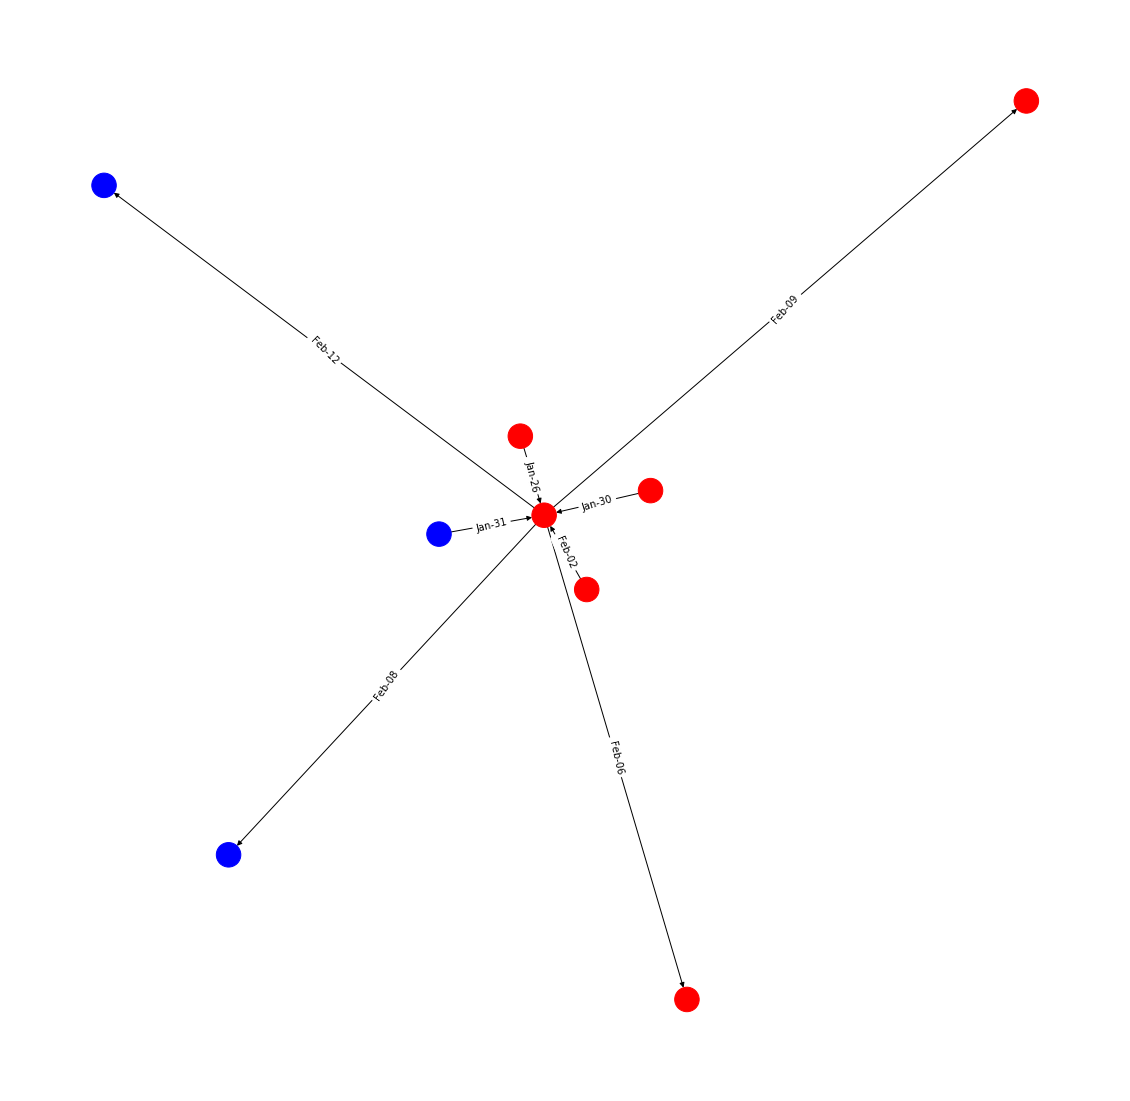

In [55]:
%%local
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
#e.head()
G = nx.from_pandas_edgelist(demo_alert,source='src',
                                   target='dst',edge_attr=True,
                                   create_using=nx.DiGraph())

demo_nodes = demo_nodes[(demo_nodes["type"]==0)]
organization_list = demo_nodes['id'].tolist()

val_map = {}
values = [val_map.get(node, 600) for node in G.nodes()]

edge_labels=dict([((u,v,),d['tran_timestamp']) for u,v,d in G.edges(data=True)])
node_colors = ['blue' if not node in organization_list else 'red' for node in G.nodes()]

pos=nx.spring_layout(G)
nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels)
nx.draw(G,pos, node_size=values, edge_color='black',edge_cmap=plt.cm.Reds, node_color = node_colors) #, with_labels = True
plt.show()

In [57]:
# scatter_gather
demo_nodes, demo_alert = prep_alert_for_ploting(alert_id="20")

In [58]:
%%spark -o demo_nodes

In [59]:
%%spark -o demo_alert

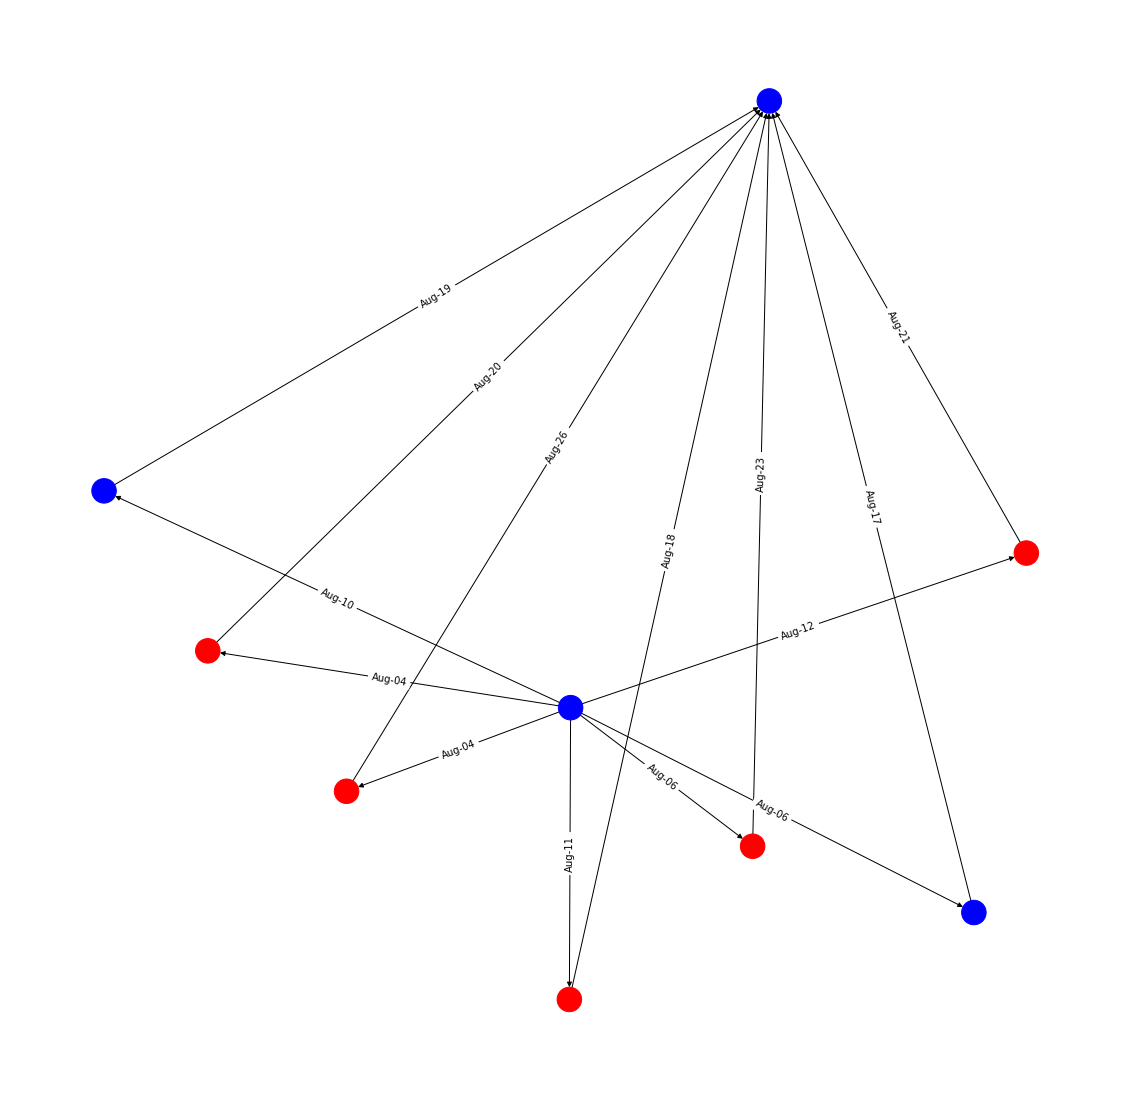

In [60]:
%%local
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
#e.head()
G = nx.from_pandas_edgelist(demo_alert,source='src',
                                   target='dst',edge_attr=True,
                                   create_using=nx.DiGraph())

demo_nodes = demo_nodes[(demo_nodes["type"]==0)]
organization_list = demo_nodes['id'].tolist()

val_map = {}
values = [val_map.get(node, 600) for node in G.nodes()]

edge_labels=dict([((u,v,),d['tran_timestamp']) for u,v,d in G.edges(data=True)])
node_colors = ['blue' if not node in organization_list else 'red' for node in G.nodes()]

pos=nx.spring_layout(G)
nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels)
nx.draw(G,pos, node_size=values, edge_color='black',edge_cmap=plt.cm.Reds, node_color = node_colors) #, with_labels = True
plt.show()

In [62]:
#cycle
demo_nodes, demo_alert = prep_alert_for_ploting(alert_id="71")

In [63]:
%%spark -o demo_nodes

In [64]:
%%spark -o demo_alert

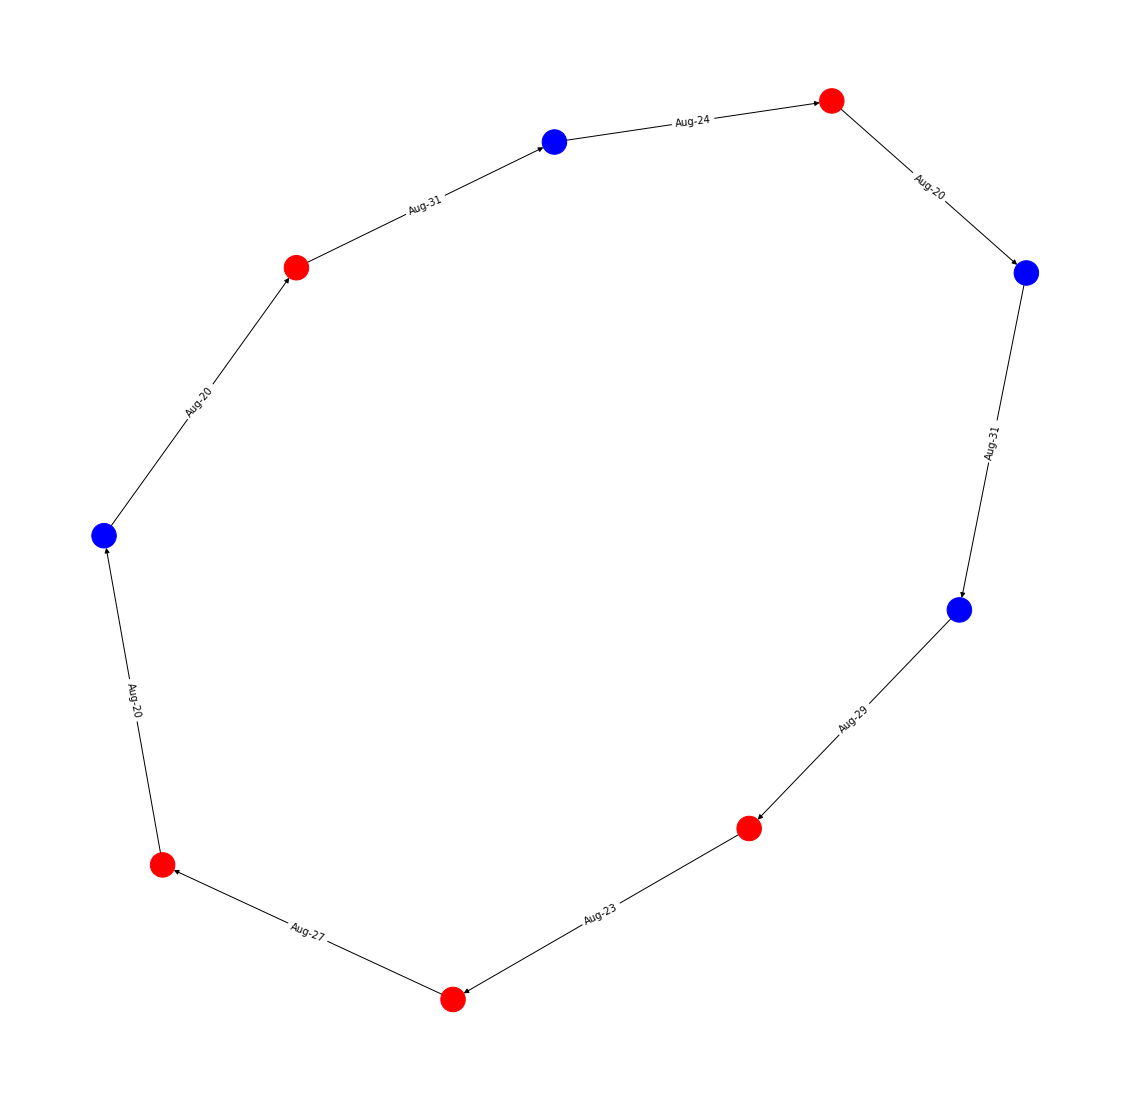

In [67]:
%%local
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
#e.head()
G = nx.from_pandas_edgelist(demo_alert,source='src',
                                   target='dst',edge_attr=True,
                                   create_using=nx.DiGraph())

demo_nodes = demo_nodes[(demo_nodes["type"]==0)]
organization_list = demo_nodes['id'].tolist()

val_map = {}
values = [val_map.get(node, 600) for node in G.nodes()]

edge_labels=dict([((u,v,),d['tran_timestamp']) for u,v,d in G.edges(data=True)])
node_colors = ['blue' if not node in organization_list else 'red' for node in G.nodes()]

pos=nx.spring_layout(G)
nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels)
nx.draw(G,pos, node_size=values, edge_color='black',edge_cmap=plt.cm.Reds, node_color = node_colors) #, with_labels = True
plt.show()